In [89]:
import sys
import pg8000  
import os
import pathlib2
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import math
import seaborn as sns
%matplotlib inline
import postpatch_funcs as pf
import warnings
warnings.filterwarnings('ignore')
from bokeh.plotting import figure
#print(sys.path)

In [90]:
#code from Agata
#these are nice functions to open LIMS, make a query and then close LIMS after

def _connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432):
    conn = pg8000.connect(user=user, host=host, database=database, password=password, port=port)
    return conn, conn.cursor()

def _select(cursor, query):
    cursor.execute(query)
    columns = [ d[0] for d in cursor.description ]
    return [ dict(zip(columns, c)) for c in cursor.fetchall() ]

def limsquery(query, user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432):
    """A function that takes a string containing a SQL query, connects to the LIMS database and outputs the result."""
    conn, cursor = _connect(user, host, database, password, port)
    try:
        results = _select(cursor, query)
    finally:
        
        #THESE ARE IMPORTANT!!!!!!
        #Every query needs to be closed when done
        cursor.close()             
        conn.close()
    return results


#this last function will take our query results and put them in a dataframe so that they are easy to work with
def get_lims_dataframe(query):
    '''Return a dataframe with lims query'''
    result = limsquery(query)
    try:
        data_df = pd.DataFrame(data=result, columns=result[0].keys())
    except IndexError:
        print "Could not find results for your query."
        data_df = pd.DataFrame()
    return data_df

In [91]:
home = pathlib2.Path.home()
full_path = home/"documents"/"stash"/"ps-metadata-analysis"/"data"/"patch_seq_log_mouse.csv"
full_path = str(full_path)
full_path
initial = pd.read_csv(full_path)

In [92]:
ps = initial[['Date', 'cell type', 'File', 'Post patch?', 'Post patch pipette R' , 'PCR cycles', 'SM_QC_PF', 'Bad dates']]
ps["File"].str.strip()

ps['Bad dates'] = ps['Bad dates'].astype('category')
ps['PCR cycles'] = ps['PCR cycles'].astype('category')
ps['cell type'] = ps['cell type'].astype('category')
ps['Post patch?'] = ps['Post patch?'].astype('category')
ps = ps[ps['PCR cycles'] == 21]
ps = ps[ps['Bad dates'] != 'x']
ps = ps[ps['SM_QC_PF'] != 'cnt']
ps = ps[(ps['cell type'] == 'tdt+') | (ps['cell type'] == 'Cre+')]
ps.dropna(subset = ['Post patch?'], inplace = True)
ps.tail()

,Date,cell type,File,Post patch?,Post patch pipette R,PCR cycles,SM_QC_PF,Bad dates
5963,180409,Cre+,Rbp4-Cre_KL100;Ai14-383389.04.01.01,nucleus_absent,1000.0,21.0,NaN,NaN
5964,180409,Cre+,Rbp4-Cre_KL100;Ai14-383389.04.01.02,nucleus_absent,1000.0,21.0,NaN,NaN
5965,180409,Cre+,Rbp4-Cre_KL100;Ai14-383389.04.01.03,nucleus_absent,1000.0,21.0,NaN,NaN
5966,180409,Cre+,Rbp4-Cre_KL100;Ai14-383389.04.01.04,nucleus_present,1000.0,21.0,NaN,NaN
5967,180409,Cre+,Pvalb-IRES-Cre;Ai14-383626.03.02.01,nucleus_absent,5.0,21.0,NaN,NaN


In [93]:
ps = pf.postpatch_reclass(ps)
ps['post patch class'] = ps['post patch class'].astype('category', categories=['Nucleated', 'Partial nucleated', 'Outside out', 'No seal', 'Entire cell'])

In [94]:
lims_query = "SELECT cell.name as cell_name, donors.full_genotype as fullgenotype \
FROM specimens cell JOIN donors ON cell.donor_id = donors.id \
WHERE cell.ephys_roi_result_id IS NOT NULL"

lims_df = get_lims_dataframe(lims_query)
lims_df.tail()

,fullgenotype,cell_name
14581,Chrna2-Cre_OE25/wt;Ai14(RCL-tdT)/wt,Chrna2-Cre_OE25;Ai14-355016.05.02.01
14582,Chrna2-Cre_OE25/wt;Ai14(RCL-tdT)/wt,Chrna2-Cre_OE25;Ai14-355016.05.02.02
14583,Pvalb-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Pvalb-IRES-Cre;Ai14-378390.04.02.01
14584,Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt,Nr5a1-Cre;Ai14-378059.10.06.01
14585,Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt,Nr5a1-Cre;Ai14-378059.11.06.01


In [95]:
ps = pd.merge(left = ps, right = lims_df, left_on = 'File', right_on = 'cell_name', how = 'left')
ps.head()

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'

Exception ValueError: "Buffer dtype mismatch, expected 'Python object' but got 'double'" in 'pandas._libs.lib.is_bool_array' ignored


,Date,cell type,File,Post patch?,Post patch pipette R,PCR cycles,SM_QC_PF,Bad dates,post patch class,fullgenotype,cell_name
0,170421,tdt+,Gad2-IRES-Cre;Ai14-313294.04.01.03,Nucleated,NaN,21.0,pass,NaN,Nucleated,Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Gad2-IRES-Cre;Ai14-313294.04.01.03
1,170421,tdt+,Gad2-IRES-Cre;Ai14-313294.03.02.01,Nucleated,NaN,21.0,pass,NaN,Nucleated,Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Gad2-IRES-Cre;Ai14-313294.03.02.01
2,170421,tdt+,Gad2-IRES-Cre;Ai14-313294.03.02.02,Nucleated,NaN,21.0,pass,NaN,Nucleated,Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Gad2-IRES-Cre;Ai14-313294.03.02.02
3,170421,tdt+,Gad2-IRES-Cre;Ai14-313294.05.01.03,Nucleated,NaN,21.0,pass,NaN,Nucleated,Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Gad2-IRES-Cre;Ai14-313294.05.01.03
4,170424,tdt+,Scnn1a-Tg3-Cre;Ai14-315865.04.01.04,Nucleated,NaN,21.0,pass,NaN,Nucleated,Scnn1a-Tg3-Cre/wt;Ai14(RCL-tdT)/wt,Scnn1a-Tg3-Cre;Ai14-315865.04.01.04


In [96]:
ps = ps.drop('Date', 1)
ps = ps.drop('Bad dates', 1)
ps = ps.drop('SM_QC_PF', 1)
ps = ps.drop('PCR cycles', 1)
ps = ps.drop('cell type', 1)
ps = ps.drop('File', 1)
ps = ps.drop('cell_name', 1)
ps = ps.drop('Post patch pipette R', 1)

In [97]:
ps.tail()

,Post patch?,post patch class,fullgenotype
3175,entire_cell,Entire cell,Sst-IRES-Cre/wt;Ai14(RCL-tdT)/wt
3176,entire_cell,Entire cell,Slc17a6-IRES-Cre/wt;Ai14(RCL-tdT)/wt
3177,entire_cell,Entire cell,Npr3-IRES2-Cre/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-t...
3178,entire_cell,Entire cell,Vip-IRES-Cre/wt;Ai14(RCL-tdT)/wt
3179,entire_cell,Entire cell,Vip-IRES-Cre/wt;Ai14(RCL-tdT)/wt


In [98]:
#ps.head()
ps.dropna(subset = ['fullgenotype'], inplace = True)

In [99]:
ps['fullgenotype'].value_counts()

Vip-IRES-Cre/wt;Ai14(RCL-tdT)/wt                               334
Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt                           285
Sst-IRES-Cre/wt;Ai14(RCL-tdT)/wt                               267
Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt                              216
Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt                             214
Pvalb-IRES-Cre/wt;Ai14(RCL-tdT)/wt                             194
Chrna2-Cre_OE25/wt;Ai14(RCL-tdT)/wt                            180
Rorb-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                             154
Ndnf-IRES2-dgCre/wt;Ai14(RCL-tdT)/wt                           143
Oxtr-T2A-Cre/wt;Ai14(RCL-tdT)/wt                               118
Htr3a-Cre_NO152/wt;Ai14(RCL-tdT)/wt                             95
Cux2-CreERT2/wt;Ai14(RCL-tdT)/wt                                66
Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt                                   65
Ndnf-IRES2-dgCre/wt;Slc32a1-IRES2-FlpO/wt;Ai65(RCFL-tdT)/wt     63
Scnn1a-Tg3-Cre/wt;Ai14(RCL-tdT)/wt                            

In [100]:
types = {'Calb1-IRES2-Cre/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-tdT)/wt': 'unknown',
       'Chat-IRES-Cre-neo/wt;Ai14(RCL-tdT)/wt': 'inhibitory', 
       'Chrna2-Cre_OE25/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Crh-IRES-Cre_ZJH/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-tdT)/wt': 'inhibitory',
       'Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt': 'excitatory', 
       'Cux2-CreERT2/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Glt25d2-Cre_NF107/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Htr3a-Cre_NO152/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Htr3a-Cre_NO152/wt;Pvalb-T2A-Dre/wt;Ai66(RCRL-tdT)/wt': 'inhibitory',
       'Ndnf-IRES2-dgCre/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Ndnf-IRES2-dgCre/wt;Slc32a1-IRES2-FlpO/wt;Ai65(RCFL-tdT)/wt': 'inhibitory',
       'Nkx2-1-CreERT2/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Nos1-CreERT2/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Nos1-CreERT2/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-tdT)/wt': 'inhibitory',
       'Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Ntsr1-Cre_GN220/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Oxtr-T2A-Cre/wt;Ai14(RCL-tdT)/wt': 'mix',
       'Oxtr-T2A-Cre/wt;Pvalb-T2A-FlpO/wt;Ai65(RCFL-tdT)/wt': 'mix',
       'Pdyn-T2A-CreERT2/wt;Ai14(RCL-tdT)/wt': 'unknown',
       'Pvalb-IRES-Cre/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Rorb-IRES2-Cre/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Rorb-IRES2-Cre-neo/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Scnn1a-Tg2-Cre/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Scnn1a-Tg3-Cre/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Sim1-Cre_KJ18/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Slc17a8-IRES2-Cre/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Slc17a8-IRES2-Cre/wt;Slc32a1-IRES2-FlpO/wt;Ai65(RCFL-tdT)/wt': 'mix',
       'Slc17a8-iCre/wt;Ai14(RCL-tdT)/wt': 'excitatory',
       'Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Slc32a1-IRES2-FlpO/wt;Ai65F/wt': 'inhibitory',
       'Sst-IRES-Cre/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Tac1-IRES2-Cre/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-tdT)/wt': 'unknown',
       'Th-Cre_FI172/wt;Ai14(RCL-tdT)/wt': 'unknown',
       'Tlx3-Cre_PL56/wt;Ai14(RCL-tdT)/wt': 'unknown',
       'Vip-IRES-Cre/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Vipr2-IRES2-Cre/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Vipr2-IRES2-Cre-neo/wt;Ai14(RCL-tdT)/wt': 'inhibitory',
       'Vipr2-IRES2-Cre/wt;Pvalb-T2A-FlpO/wt;Ai65(RCFL-tdT)/wt': 'inhibitory',
       'Vipr2-IRES2-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai65(RCFL-tdT)/wt': 'inhibitory'}

#unknowns: Tac1, Tlx3, Pdyn, Th, Calb1

ps['ntype'] = ps['fullgenotype'].map(types)

In [101]:
ps.tail()

,Post patch?,post patch class,fullgenotype,ntype
3175,entire_cell,Entire cell,Sst-IRES-Cre/wt;Ai14(RCL-tdT)/wt,inhibitory
3176,entire_cell,Entire cell,Slc17a6-IRES-Cre/wt;Ai14(RCL-tdT)/wt,NaN
3177,entire_cell,Entire cell,Npr3-IRES2-Cre/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-t...,NaN
3178,entire_cell,Entire cell,Vip-IRES-Cre/wt;Ai14(RCL-tdT)/wt,inhibitory
3179,entire_cell,Entire cell,Vip-IRES-Cre/wt;Ai14(RCL-tdT)/wt,inhibitory


In [584]:
post_patch = list(ps["post patch class"].unique())
#type(post_patch)
#post_patch
cell_type = list(ps["ntype"].unique())
#cell_type
genotypes = list(ps["fullgenotype"].unique())
x = np.arange(len(genotypes))
#genotypes
bottom = np.zeros(len(genotypes))
y = np.zeros(len(genotypes))
for pp in post_patch:
    #bottom = bottom + y
    #y = [len(ps[(ps['full_genotype'] == f) & (ps['post patch class'] == pp)]) for f in genotypes]
    #plt.bar(x, y, bottom = bottom, label = pp)
    for ct in cell_type:
        w = [len(ps[(ps['fullgenotype'] == f) & (ps['post patch class'] == pp) & (ps['ntype'] == ct)]) for f in genotypes]
        z = [len(ps[(ps['fullgenotype'] ==f) & (ps['ntype'] == ct)]) for f in genotypes]
        w_array = np.array(w)
        z_array = np.array(z)
        print w_array
        #print z_array
        #y = [np.float64(a) / np.float64(b) for a,b in zip(w,z)]
        #print y
        #plt.bar(x, y, bottom = bottom, label = (pp, ct))
#plt.legend()        

[ 91   0   0   0   0   0  61   0 136 140  77   7  94   0   0   0   1  19
   0  37  26  38  19   0   0   0   0   0   0   0  13   0  15   0   3   7
   5   3   0   0]
[  0  22  43  22  14  20   0  30   0   0   0   0   0   9 119   6   0   0
  11   0   0   0   0   0  13   0   0   0   2  16   0   0   0   0   0   0
   0   0   0   0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 59  0
  0 19  0  0  0  0  6  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 15  0  5  0  0  0  0  0  7  0  0  0  0  4  0]
[24  0  0  0  0  0 28  0 33 31 13  0 18  0  0  0  0 15  0 11 11  9  3  0  0
  0  0  0  0  0  2  0  2  0  3  0  1  1  0  0]
[ 0  3 20 13  3 12  0  3  0  0  0  0  0  2 17  0  0  0  4  0  0  0  0  0  4
  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14  0
  0  3  0  0  0  0  3  0  0  0  0  0  0  0  0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 2 

In [102]:
ps1 = ps.groupby(['ntype', 'fullgenotype', 'post patch class']).agg(['count'])

In [103]:
ps1.head()

Post patch?
                                                                      count
ntype      fullgenotype                       post patch class             
excitatory Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt Nucleated                  12
                                              Partial nucleated           4
                                              No seal                     2
           Cux2-CreERT2/wt;Ai14(RCL-tdT)/wt   Nucleated                  36
                                              Partial nucleated           4

In [104]:
#postpatch = ps.groupby(['full_genotype', 'post patch class']).count()
postpatch = ps1.reset_index()
#postpatch = postpatch.pivot_table(values=['Post patch?'],
                             #index=['type', 'full_genotype'],
                             #columns='post patch class')#.agg(['sum'])
                             #aggfunc='sum', fill_value=0)

postpatch = postpatch.set_index(['ntype', 'fullgenotype', 'post patch class']).unstack(level=-1).fillna(0)

In [115]:
postpatch

Post patch?  \
                                                                    count   
post patch class                                                Nucleated   
ntype      fullgenotype                                                     
excitatory Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt                        12.0   
           Cux2-CreERT2/wt;Ai14(RCL-tdT)/wt                          36.0   
           Glt25d2-Cre_NF107/wt;Ai14(RCL-tdT)/wt                      6.0   
           Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt                             22.0   
           Ntsr1-Cre_GN220/wt;Ai14(RCL-tdT)/wt                       16.0   
           Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt                       127.0   
           Rorb-IRES2-Cre-neo/wt;Ai14(RCL-tdT)/wt                    22.0   
           Rorb-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                        43.0   
           Scnn1a-Tg2-Cre/wt;Ai14(RCL-tdT)/wt                        16.0   
           Scnn1a-Tg3-Cre/wt;Ai14(RCL-tdT)/wt                        22.0   
           Sim1-Cre_KJ18/wt;Ai14(RCL-tdT)/wt                         13.0   
           Slc17a8-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                     11.0   
           Slc17a8-iCre/wt;Ai14(RCL-tdT)/wt                           2.0   
inhibitory Chat-IRES-Cre-neo/wt;Ai14(RCL-tdT)/wt                     26.0   
           Chrna2-Cre_OE25/wt;Ai14(RCL-tdT)/wt                       95.0   
           Crh-IRES-Cre_ZJH/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-...        19.0   
           Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt                         95.0   
           Htr3a-Cre_NO152/wt;Ai14(RCL-tdT)/wt                       54.0   
           Htr3a-Cre_NO152/wt;Pvalb-T2A-Dre/wt;Ai66(RCRL-t...         7.0   
           Ndnf-IRES2-dgCre/wt;Ai14(RCL-tdT)/wt                      58.0   
           Ndnf-IRES2-dgCre/wt;Slc32a1-IRES2-FlpO/wt;Ai65(...        30.0   
           Nos1-CreERT2/wt;Ai14(RCL-tdT)/wt                           5.0   
           Nos1-CreERT2/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-tdT)/wt        30.0   
           Pvalb-IRES-Cre/wt;Ai14(RCL-tdT)/wt                        79.0   
           Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt                     145.0   
           Slc32a1-IRES2-FlpO/wt;Ai65F/wt                             7.0   
           Sst-IRES-Cre/wt;Ai14(RCL-tdT)/wt                         147.0   
           Vip-IRES-Cre/wt;Ai14(RCL-tdT)/wt                         165.0   
           Vipr2-IRES2-Cre-neo/wt;Ai14(RCL-tdT)/wt                    1.0   
           Vipr2-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                        3.0   
           Vipr2-IRES2-Cre/wt;Pvalb-T2A-FlpO/wt;Ai65(RCFL-...         3.0   
           Vipr2-IRES2-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai65(RCF...        19.0   
mix        Oxtr-T2A-Cre/wt;Ai14(RCL-tdT)/wt                          63.0   
           Oxtr-T2A-Cre/wt;Pvalb-T2A-FlpO/wt;Ai65(RCFL-tdT...         7.0   
unknown    Calb1-IRES2-Cre/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-t...         0.0   
           Pdyn-T2A-CreERT2/wt;Ai14(RCL-tdT)/wt                      15.0   
           Tac1-IRES2-Cre/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-td...         8.0   
           Th-Cre_FI172/wt;Ai14(RCL-tdT)/wt                           8.0   
           Tlx3-Cre_PL56/wt;Ai14(RCL-tdT)/wt                          5.0   

                                                                                 \
                                                                                  
post patch class                                              Partial nucleated   
ntype      fullgenotype                                                           
excitatory Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt                               4.0   
           Cux2-CreERT2/wt;Ai14(RCL-tdT)/wt                                 4.0   
           Glt25d2-Cre_NF107/wt;Ai14(RCL-tdT)/wt                            0.0   
           Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt                                   14.0   
           Ntsr1-Cre_GN220/wt;Ai14(RCL-tdT)/wt                              3.0   
   

In [106]:
postpatch_percent = postpatch.div(postpatch.sum(1), axis=0)*100

In [107]:
postpatch_percent

Post patch?  \
                                                                    count   
post patch class                                                Nucleated   
ntype      fullgenotype                                                     
excitatory Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt                   66.666667   
           Cux2-CreERT2/wt;Ai14(RCL-tdT)/wt                     54.545455   
           Glt25d2-Cre_NF107/wt;Ai14(RCL-tdT)/wt                75.000000   
           Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt                        33.846154   
           Ntsr1-Cre_GN220/wt;Ai14(RCL-tdT)/wt                  51.612903   
           Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt                   59.345794   
           Rorb-IRES2-Cre-neo/wt;Ai14(RCL-tdT)/wt               43.137255   
           Rorb-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                   27.922078   
           Scnn1a-Tg2-Cre/wt;Ai14(RCL-tdT)/wt                   57.142857   
           Scnn1a-Tg3-Cre/wt;Ai14(RCL-tdT)/wt                   35.483871   
           Sim1-Cre_KJ18/wt;Ai14(RCL-tdT)/wt                    50.000000   
           Slc17a8-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                55.000000   
           Slc17a8-iCre/wt;Ai14(RCL-tdT)/wt                     66.666667   
inhibitory Chat-IRES-Cre-neo/wt;Ai14(RCL-tdT)/wt                42.622951   
           Chrna2-Cre_OE25/wt;Ai14(RCL-tdT)/wt                  52.777778   
           Crh-IRES-Cre_ZJH/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-...   51.351351   
           Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt                    43.981481   
           Htr3a-Cre_NO152/wt;Ai14(RCL-tdT)/wt                  56.842105   
           Htr3a-Cre_NO152/wt;Pvalb-T2A-Dre/wt;Ai66(RCRL-t...   50.000000   
           Ndnf-IRES2-dgCre/wt;Ai14(RCL-tdT)/wt                 40.559441   
           Ndnf-IRES2-dgCre/wt;Slc32a1-IRES2-FlpO/wt;Ai65(...   47.619048   
           Nos1-CreERT2/wt;Ai14(RCL-tdT)/wt                     62.500000   
           Nos1-CreERT2/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-tdT)/wt   69.767442   
           Pvalb-IRES-Cre/wt;Ai14(RCL-tdT)/wt                   40.721649   
           Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt                 50.877193   
           Slc32a1-IRES2-FlpO/wt;Ai65F/wt                       77.777778   
           Sst-IRES-Cre/wt;Ai14(RCL-tdT)/wt                     55.056180   
           Vip-IRES-Cre/wt;Ai14(RCL-tdT)/wt                     49.401198   
           Vipr2-IRES2-Cre-neo/wt;Ai14(RCL-tdT)/wt             100.000000   
           Vipr2-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                  37.500000   
           Vipr2-IRES2-Cre/wt;Pvalb-T2A-FlpO/wt;Ai65(RCFL-...   37.500000   
           Vipr2-IRES2-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai65(RCF...   34.545455   
mix        Oxtr-T2A-Cre/wt;Ai14(RCL-tdT)/wt                     53.389831   
           Oxtr-T2A-Cre/wt;Pvalb-T2A-FlpO/wt;Ai65(RCFL-tdT...   38.888889   
unknown    Calb1-IRES2-Cre/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-t...    0.000000   
           Pdyn-T2A-CreERT2/wt;Ai14(RCL-tdT)/wt                 39.473684   
           Tac1-IRES2-Cre/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-td...   72.727273   
           Th-Cre_FI172/wt;Ai14(RCL-tdT)/wt                     38.095238   
           Tlx3-Cre_PL56/wt;Ai14(RCL-tdT)/wt                    45.454545   

                                                                                 \
                                                                                  
post patch class                                              Partial nucleated   
ntype      fullgenotype                                                           
excitatory Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt                         22.222222   
           Cux2-CreERT2/wt;Ai14(RCL-tdT)/wt                            6.060606   
           Glt25d2-Cre_NF107/wt;Ai14(RCL-tdT)/wt                       0.000000   
           Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt                              21.538462   
           Ntsr1-Cre_GN220/wt;Ai14(RCL-tdT)/wt                         9.677419   
   

In [108]:
postpatch_percent.to_dict('dict')

{('Post patch?',
  'count',
  'Entire cell'): {('excitatory',
   u'Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt'): 0.0, ('excitatory',
   u'Cux2-CreERT2/wt;Ai14(RCL-tdT)/wt'): 0.0, ('excitatory',
   u'Glt25d2-Cre_NF107/wt;Ai14(RCL-tdT)/wt'): 0.0, ('excitatory',
   u'Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt'): 0.0, ('excitatory',
   u'Ntsr1-Cre_GN220/wt;Ai14(RCL-tdT)/wt'): 0.0, ('excitatory',
   u'Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt'): 0.46728971962616817, ('excitatory',
   u'Rorb-IRES2-Cre-neo/wt;Ai14(RCL-tdT)/wt'): 1.9607843137254901, ('excitatory',
   u'Rorb-IRES2-Cre/wt;Ai14(RCL-tdT)/wt'): 1.2987012987012987, ('excitatory',
   u'Scnn1a-Tg2-Cre/wt;Ai14(RCL-tdT)/wt'): 3.571428571428571, ('excitatory',
   u'Scnn1a-Tg3-Cre/wt;Ai14(RCL-tdT)/wt'): 0.0, ('excitatory',
   u'Sim1-Cre_KJ18/wt;Ai14(RCL-tdT)/wt'): 3.8461538461538463, ('excitatory',
   u'Slc17a8-IRES2-Cre/wt;Ai14(RCL-tdT)/wt'): 0.0, ('excitatory',
   u'Slc17a8-iCre/wt;Ai14(RCL-tdT)/wt'): 0.0, ('inhibitory',
   u'Chat-IRES-Cre-neo/wt;Ai14(RCL-tdT)/wt'

In [77]:
postpatch_totals = list(postpatch.sum(1))
postpatch_totals = [int(x) for x in postpatch_totals]
#postpatch_totals

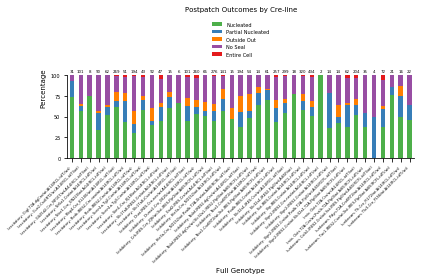

In [78]:
pal = ['#4daf4a', '#377eb8', '#ff7f00', '#984ea3', '#e41a1c']
ax1 = postpatch_percent.plot(kind = 'bar', stacked = True, color = pal)

axes = plt.gca()
axes.set_ylim(0,170)
plt.yticks([0,25,50,75,100], size = '5')
plt.xticks(size=3.5, rotation=45, ha='right')
#plt.legend(loc='upper right', prop={'size':5})
plt.xlabel('Full Genotype', fontsize='7')
plt.ylabel('Percentage', fontsize='7')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_bounds(0, 100)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
barWidth = 1

plt.title('Postpatch Outcomes by Cre-line', fontsize='7')
ax1.legend(["Nucleated", "Partial Nucleated", "Outside Out", "No Seal", "Entire Cell"], loc='upper center', frameon=False, fontsize='5', )

rects = ax1.patches
labels = postpatch_totals

for rect, label in zip (rects, labels):
    height = 103
    x_value = rect.get_x() + rect.get_width() / 2
    ax1.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom', size=4)
    
plt.tight_layout()
#fig_path = home/"documents"/"stash"/"ps-metadata-analysis"/"figures"/"patch_seq_log_mouse.csv"
plt.savefig('c:/users/rustym/documents/stash/ps-metadata-analysis/figures/postpatch_by_creline2', dpi=300)

In [79]:
ps2

In [53]:
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure
from bokeh.palettes import Spectral5
from bokeh.sampledata.autompg import autompg_clean as df
from bokeh.transform import factor_cmap

In [88]:
ps['ntype'] = ps['ntype'].astype(str)
#df.yr = df.yr.astype(str)

ps2 = ps.groupby(['ntype', 'fullgenotype', 'post patch class']).agg(['count'])
source = ColumnDataSource(ps2)
index_cmap = factor_cmap('ntype_fullgenotype', palette=Spectral5, factors=sorted(ps['ntype'].unique()), end=1)

ps2

Post patch?  \
                                                                    count   
ntype      fullgenotype                                                     
excitatory Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt                          31   
           Cux2-CreERT2/wt;Ai14(RCL-tdT)/wt                           101   
           Glt25d2-Cre_NF107/wt;Ai14(RCL-tdT)/wt                        8   
           Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt                               90   
           Ntsr1-Cre_GN220/wt;Ai14(RCL-tdT)/wt                         62   
           Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt                         269   
           Rorb-IRES2-Cre-neo/wt;Ai14(RCL-tdT)/wt                      51   
           Rorb-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                         194   
           Scnn1a-Tg2-Cre/wt;Ai14(RCL-tdT)/wt                          43   
           Scnn1a-Tg3-Cre/wt;Ai14(RCL-tdT)/wt                          92   
           Sim1-Cre_KJ18/wt;Ai14(RCL-tdT)/wt                           47   
           Slc17a8-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                       15   
           Slc17a8-iCre/wt;Ai14(RCL-tdT)/wt                             6   
inhibitory Chat-IRES-Cre-neo/wt;Ai14(RCL-tdT)/wt                      101   
           Chrna2-Cre_OE25/wt;Ai14(RCL-tdT)/wt                        260   
           Crh-IRES-Cre_ZJH/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-...          65   
           Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt                          276   
           Htr3a-Cre_NO152/wt;Ai14(RCL-tdT)/wt                        141   
           Htr3a-Cre_NO152/wt;Pvalb-T2A-Dre/wt;Ai66(RCRL-t...          15   
           Ndnf-IRES2-dgCre/wt;Ai14(RCL-tdT)/wt                       194   
           Ndnf-IRES2-dgCre/wt;Slc32a1-IRES2-FlpO/wt;Ai65(...          54   
           Nos1-CreERT2/wt;Ai14(RCL-tdT)/wt                            14   
           Nos1-CreERT2/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-tdT)/wt          61   
           Pvalb-IRES-Cre/wt;Ai14(RCL-tdT)/wt                         257   
           Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt                       299   
           Slc32a1-IRES2-FlpO/wt;Ai65F/wt                              18   
           Sst-IRES-Cre/wt;Ai14(RCL-tdT)/wt                           320   
           Vip-IRES-Cre/wt;Ai14(RCL-tdT)/wt                           434   
           Vipr2-IRES2-Cre-neo/wt;Ai14(RCL-tdT)/wt                      2   
           Vipr2-IRES2-Cre/wt;Ai14(RCL-tdT)/wt                         14   
           Vipr2-IRES2-Cre/wt;Pvalb-T2A-FlpO/wt;Ai65(RCFL-...          14   
           Vipr2-IRES2-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai65(RCF...          62   
mix        Oxtr-T2A-Cre/wt;Ai14(RCL-tdT)/wt                           204   
           Oxtr-T2A-Cre/wt;Pvalb-T2A-FlpO/wt;Ai65(RCFL-tdT...          35   
nan        Slc17a6-IRES-Cre/wt;Ai14(RCL-tdT)/wt                         7   
unknown    Calb1-IRES2-Cre/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-t...           4   
           Pdyn-T2A-CreERT2/wt;Ai14(RCL-tdT)/wt                        72   
           Tac1-IRES2-Cre/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-td...          21   
           Th-Cre_FI172/wt;Ai14(RCL-tdT)/wt                            16   
           Tlx3-Cre_PL56/wt;Ai14(RCL-tdT)/wt                           22   

                                                              post patch class  
                                                                         count  
ntype      fullgenotype                                                         
excitatory Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt                               31  
           Cux2-CreERT2/wt;Ai14(RCL-tdT)/wt                                101  
           Glt25d2-Cre_NF107/wt;Ai14(RCL-tdT)/wt                             8  
           Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt                                    90  
           Ntsr1-Cre_GN220/wt;Ai14(RCL-tdT)/wt                              62  
           Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt                              269  
           Rorb-IRES2

In [ ]:
p = figure(plot_width=800, plot_height=300, title="Mean MPG by # Cylinders and Manufacturer",
           x_range=ps2, toolbar_location=None, tools="")

p.vbar(x='ntype_fullgenotype_post patch class', top='post patch class_mean', width=1, source=source,
       line_color="white", fill_color=index_cmap, )

show(p)

In [121]:
pp_percent = pd.DataFrame(postpatch_percent.to_records())
#postpatch_percent
pp_percent

,ntype,fullgenotype,"('Post patch?', 'count', 'Nucleated')","('Post patch?', 'count', 'Partial nucleated')","('Post patch?', 'count', 'Outside out')","('Post patch?', 'count', 'No seal')","('Post patch?', 'count', 'Entire cell')"
0,excitatory,Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt,66.666667,22.222222,0.000000,11.111111,0.000000
1,excitatory,Cux2-CreERT2/wt;Ai14(RCL-tdT)/wt,54.545455,6.060606,1.515152,37.878788,0.000000
2,excitatory,Glt25d2-Cre_NF107/wt;Ai14(RCL-tdT)/wt,75.000000,0.000000,0.000000,25.000000,0.000000
3,excitatory,Nr5a1-Cre/wt;Ai14(RCL-tdT)/wt,33.846154,21.538462,4.615385,40.000000,0.000000
4,excitatory,Ntsr1-Cre_GN220/wt;Ai14(RCL-tdT)/wt,51.612903,9.677419,3.225806,35.483871,0.000000
5,excitatory,Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt,59.345794,11.214953,10.280374,18.691589,0.467290
6,excitatory,Rorb-IRES2-Cre-neo/wt;Ai14(RCL-tdT)/wt,43.137255,25.490196,9.803922,19.607843,1.960784
7,excitatory,Rorb-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,27.922078,12.987013,17.532468,40.259740,1.298701
8,excitatory,Scnn1a-Tg2-Cre/wt;Ai14(RCL-tdT)/wt,57.142857,10.714286,3.571429,25.000000,3.571429
9,excitatory,Scnn1a-Tg3-Cre/wt;Ai14(RCL-tdT)/wt,35.483871,4.838710,20.967742,38.709677,0.000000


In [191]:
from itertools import groupby

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, rotation=90, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= 1.75


In [192]:
#pp_p = pp_percent.groupby([])

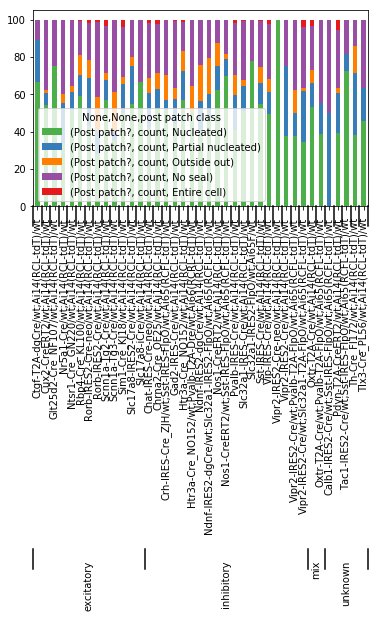

In [193]:
pal = ['#4daf4a', '#377eb8', '#ff7f00', '#984ea3', '#e41a1c']
fig = plt.figure()
ax = fig.add_subplot(111)
postpatch_percent.plot(kind = 'bar', stacked = True, ax=fig.gca(), color = pal)
labels = ['' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_xlabel('')
label_group_bar_table(ax, postpatch_percent)
fig.subplots_adjust(bottom=.1*postpatch_percent.index.nlevels)

In [132]:
from itertools import groupby

def test_table():
    data_table = pd.DataFrame({'Room':['Room A']*4 + ['Room B']*4,
                               'Shelf':(['Shelf 1']*2 + ['Shelf 2']*2)*2,
                               'Staple':['Milk','Water','Sugar','Honey','Wheat','Corn','Chicken','Cow'],
                               'Quantity':[10,20,5,6,4,7,2,1],
                               'Ordered':np.random.randint(0,10,8)
                               })
    return data_table

In [133]:
table = test_table()
table

,Ordered,Quantity,Room,Shelf,Staple
0,6,10,Room A,Shelf 1,Milk
1,6,20,Room A,Shelf 1,Water
2,2,5,Room A,Shelf 2,Sugar
3,9,6,Room A,Shelf 2,Honey
4,3,4,Room B,Shelf 1,Wheat
5,0,7,Room B,Shelf 1,Corn
6,6,2,Room B,Shelf 2,Chicken
7,1,1,Room B,Shelf 2,Cow


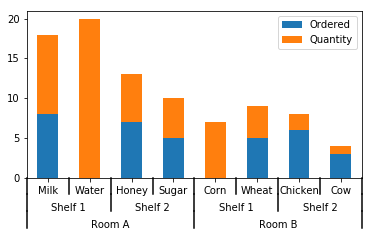

In [202]:
df = test_table().groupby(['Room','Shelf','Staple']).sum()
def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1


fig = plt.figure()
ax = fig.add_subplot(111)
df.plot(kind='bar',stacked=True,ax=fig.gca())
#Below 3 lines remove default labels
labels = ['' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_xlabel('')
label_group_bar_table(ax, df)
fig.subplots_adjust(bottom=.1*df.index.nlevels)
plt.show()

In [ ]:
plt.figure()
ax = plt.gca()

postpatch_percent.plot(kind = 'bar', stacked = True, ax=ax, color = pal)